# Advanced Multivariate Statistics
# Lecture 1 - `scikit-learn` Refresher

Let's explore the typical modelling workflow of a supervised classification problem. We shall look at the "census" data, the details of which can be seen [here](https://www.openml.org/search?type=data&sort=runs&id=1590&status=active). The data is about around 50 thousands US citizens, extracted from the 1994 Census database. The prediction task is to determine whether a person makes over 50K a year. In particular, we will be re-fitting the same models to the same data, each time adding one piece to incrementally build a more comprehensive modelling workflow. We shall:

1. Look at different strategies to deal with categorical data.
2. Compare the performance of different models.
3. See cross-validation and grid search to find optimal parameters.

In [ ]:
from sklearn import set_config
set_config(display='diagram')

We run the cell above to make sure our scikit-learn models and pipelines can be displayed as nice HTML diagrams.

## Data Exploration

Toy datasets from OpenML can be obtained without download using the `fetch_openml` function and their unique identifier function from `scikit-learn`:

In [ ]:
from sklearn.datasets import fetch_openml

census = fetch_openml(data_id=1590).frame

census.head()

The columns are self explanatory, except `fnlwgt`, which stands for `final_weight`, a proxy for the demographic background of the people: "People with similar demographic characteristics should have similar weights".

Let's explore the dataset:

In [ ]:
census.describe()

In [ ]:
census.info()

The null count is pretty low and the qualitative columns are already encoded as `category` (a dedicated and more efficient pandas datatype for qualitative data). It seems that the data might not need a lot of processing: this rarely holds in real world settings, where data manipulation does take more time.

One note: given the great number of categorical features, we could plot as many pairplots to spot patterns. We might want to be more selective or to use different approaches when - say - we have a very large number of features. In this case, we also happen to have nearly 50k datapoints for each variable: plotting can take a considerable amount of time, and thus we might want to let our domain knowledge/expertise/intuition guide us.

In these cases, we might want to use a `heatmap` to display the `corrplot`, i.e. a grid plotting the correlation across variables:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = census.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corrplot = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
    )

From this we can see that education is a feature that will be correlated with many variables. However, it is evident that high-level functions can only take us so far: we need to handle the categorical features and to explore the data.

One such way is to use the `pd.get_dummies` function, that "explodes" each categorical feature in a binary column - this is easier to see than to explain.

In [ ]:
import pandas as pd

pd.get_dummies(census).head()

This, however, explodes the dataset: here we have 107 columns, which are overkill. The reason is that the function explodes every column by default, thus increasing the costs of running our algorithms.

This naive binarization strategy, also known as `OneHotEncoding`, is indeed a *dummy* or naive strategy, because there are other alternatives. We shall explore some of them.

## Before Any Modelling Happens: Train/Test Splitting

First, let's set aside the target variable (the `y`) and the covariates (or features, the `X`):


In [ ]:
target_name = "class"

target = census[target_name]
data = census.drop(columns = target_name)

At the same time, we **must set aside a portion of the data that shall be used to evaluate our data on. This part of the data will be known as test set**. What we do is basically set aside a piece of the dataset and make sure we do not manipulate it until we are actually testing the performance of the model on unseen data.

This kind of separation/isolation is necessary: suppose we normalise the data before splitting train and test set. This would mean that some information of the test set would be used to compute the mean and standard deviation of the data, thus resulting in a *contanimation* of our data (also known as [*data leakage*](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage)).

We could manually split the data using indexing; however, scikit-learn already offers very useful functions to avoid code duplication:

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42, test_size=0.25
)

## First Step: Establishing a Baseline

Fitting a model is easy:

    from sklearn.linear_model import LogisticRegression

    log_reg = LogisticRegression()

    _ = log_reg.fit(data_train, target_train)

However, fitting the model would fail. Why? Because - as we said above - we have not dealt with categorical columns.

For this reason, we should write a more complex pipeline to deal with this. We have already seen in the previous notebook on unsupervised learning how to write one:

1. Create a `selector` to extract categorical and quantitative columns and use it to extract the column names.
2. Create a `preprocessor`:
    1. A standard scaler for the quantitative data: this is mandatory for distance-based algorithms such as the `KNeighboursRegressor`, but can also make other algorithms converge faster. This is the case for the `LogisticRegression`!
    2. A `OneHotEncoder` (that produces binary/dummy variables) for categorical data.
3. Create the `ColumnTransformer` that will apply the transformations to the data
4. Put the `ColumnTransformer` into a `Pipeline` with the model we want to use

Let's start with the preprocessors:

In [ ]:
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numerical_columns_selector = selector(dtype_exclude="category")
categorical_columns_selector = selector(dtype_include="category")

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()

In [ ]:
census[categorical_columns]

Then we instantiate the Transformer and the Pipeline.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

column_preprocessor = ColumnTransformer(
    transformers = [
        ("categories", categorical_preprocessor, categorical_columns),
        ("numerical", numerical_preprocessor, numerical_columns)
    ]
)

logreg_model = LogisticRegression(max_iter=500)

logreg_pipeline = Pipeline(
    steps = [
        ("preprocessing", column_preprocessor),
        ("logistic_regression", logreg_model)
    ]
)

logreg_pipeline

Take a moment to notice how helpful it can be to inspect the pipeline steps with the diargram. The next time we want to create a different model, we can reuse the `ColumnTransformer` or any of the preprocessors: the investment we made in writing this code will pay soon off!

Now we can fit the pipeline:

In [ ]:
_ = logreg_pipeline.fit(data_train, target_train)

We can use the model to make predictions using the `.predict()` method:

In [ ]:
logreg_pipeline.predict(data_test[:5])

This returns the array of the predicted values - note these are already encoded as the classes of the `target` column! We can compare these values with the true ones:

In [ ]:
target_test[:5].values

How do we measure the error? We could implement a function, but actually there is already a method to compute the accuracy automatically!

In [ ]:
accuracy = logreg_pipeline.score(data_test, target_test)

print(f"Accuracy of logistic regression: {accuracy:.3f}")

Our baseline is 86% accurate - which seems to be a good result for a model that has no feature engineering and a rudimentary categorical encoding strategy. Not only that, but we did not tune any hyperparameter of the model!

However, what we have done is slightly unorthodox and not recommended. Why? Suppose we wanted to try out mode modelling strategies, e.g. fitting more models. How do we choose the better one? Do we check for the accuracy score on the test set? Turns out, we should not.

## Compare Different Models with Cross-Validation

If we computed the accuracy of multiple models on the test set and choose the better one, we would have broken our promise not to touch the test set. The test set should only be used to verify the performance of the very best model we come up with during our experimentation!

What we do is to create some "artificial" test sets when we fit our model, and compute our metric scores on that. This procedure is called cross validation (or CV). There are [many kinds of CV](https://scikit-learn.org/stable/modules/cross_validation.html#), but the most common with tabular data is called **KFold** cross validation.

This algorithm splits the data in K chunks. Then, the model is fit on K - 1 chunks, while the last chunk is used to compute the accuracy. This procedure is done with all the permutations of the folds, i.e. until every individual chunk is used to compute the error.

In the image below, we see that with `K=5` the model will be fit on the red datapoints and tested on the blue ones. The blue partition will shift four more times, and the model will be *trained and tested* five times.


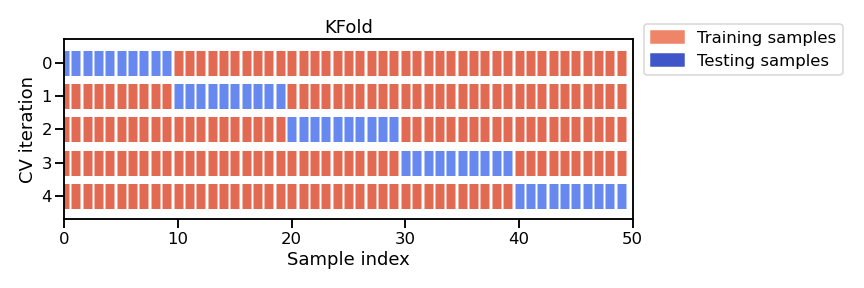

We can call the `cross_validate` function to do this automatically:

In [ ]:
from sklearn.model_selection import cross_validate

cv_result_logreg = cross_validate(logreg_pipeline, data_train, target_train, cv=5)

cv_result_logreg

The `cv_result` object is a dictionary that contains the metrics of each model iteration.

From a statistical standpoint, every measurement in the `test_score` array is a statistic, i.e. a realisation of the true generative process. What this means is that an individual score is just not enough and that **good performance may only be driven by chance**!

Cross validation allows us to compute multiple statistics on different parts of the data, and then we can use them to obtain more reliable statistics of the performance of the model.

In [ ]:
def print_score(cv_result):
    print(
        "The mean cross-validation accuracy is: "
        f"{cv_result['test_score'].mean():.3f} ± {cv_result['test_score'].std():.3f}"
    )

In [ ]:
print_score(cv_result_logreg)

This means we can now compare different modelling pipelines! The regression has nice properties that make it suitable to use - not only as a baseline as we did. It is easy to interpret and can be extended easily with cleaver feature engineering. However, for tabular data, gradient boosted trees are powerful methods that can also be used to establish a baseline.

The nice thing with these trees is that:

1. `OrdinalEncoding` is enough: this is an encoding strategy that converts every category of a variable in a sequence from 1 to n. This works best when you have features such as the days of the week, where the **ordering matters and has meaning**. In our case, converting the 51 states using ordinal encoding does not make a lot of sense: why should one state be numbered 1, 14, or 15? Remember: ordinal econding converts number into a sequence of numbers and the `is lesser/greater than` relationship matters! Luckily for us, boosted trees don't care about this sequencing. This is actually better, because we don't have to explode a column into n other ones as we do with one-hot encoding.
2. They can learn non-linear relationships
3. They can deal with missing datapoints

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

ordinal_enc_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers = [('categorical', ordinal_enc_preprocessor, categorical_columns)],
    # leave the other columns as-is
    remainder="passthrough"
    )

boosted_pipeline = Pipeline(
    steps = [
        ("ordinal_encoder", preprocessor),
        ("gbtree", HistGradientBoostingClassifier())
    ]
)

boosted_pipeline

In [ ]:
cv_result_tree = cross_validate(boosted_pipeline, data_train, target_train, cv=5)

In [ ]:
print_score(cv_result_tree)

Simply by using the tree, we improved our performance by 2%. This however is just the beginning of the data scientist's work: we have established the baseline, and now we might enter a loop made up of more feature engineering and hyperparameter tuning to keep getting better.

## Hyperparameter Tuning with GridSearch

When we say that a model "learns", we are basically saying that it's reiterating a procedure that will yield the better parameters, i.e. the coefficients of every variable. This is not always the case: trees, for example, are called 'non-parametric' methods because they learn where to split the data in a non-linear fashion.

What matters is that every model has its own "meta" or hyperpameters that influence how the model will find these parameters. The optimal hyperparameters (since they are "meta" parameters) are not learnt. We can thus use different approaces to find the better ones - all of which involve training multiple models. The most basic strategy is called `GridSearchCV` and basically iterates over a grid, or combination, of hyperparameters.

Let's try it with the `HistGradientBoostingClassifier`.

Since the pipeline is already available, we don't have to write much more code - just the grid of hyperparameters we want to use. This is a dictionary whose keys are made up of two parts:

1. The name we gave to the model in our pipeline (in this case, `gbtree`)
2. The name of the hyperparameter, separated by *two* underscores.

This notation is what is used internally by scikit-learn to understand what parameters we are referring to. We can find all the hyperparameters on the documentaton, or by calling the `.get_params().keys()` method on the instantiated model/pipeline:

In [ ]:
boosted_pipeline.get_params().keys()

Suppose we want to use the following grid:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'gbtree__learning_rate': (0.01, 0.1, 1, 10),
    'gbtree__max_leaf_nodes': (3, 10, 30)}

model_grid_search = GridSearchCV(
    boosted_pipeline, param_grid=param_grid, n_jobs=-1, cv=5 # inner CV
)

model_grid_search

In [ ]:
_ = model_grid_search.fit(data_train, target_train)

What's happening internally is that the model is running a combination of all the possible hyperparams ($4 \times 3$) on a 5-fold cross validation: this means 60 models are fit! This kind of hyperparameter optimisation can become too expensive to soon.

We can access the results of the grid search like this:

In [ ]:
import pandas as pd
grid_search_cv_results = (
    pd.DataFrame(model_grid_search.cv_results_)
    .sort_values("rank_test_score")
    .filter(["params", "mean_test_score", "std_test_score", "rank_test_score"])
)

grid_search_cv_results.head()

This best model has 87.1% accuracy with a 0.3% standard error - not a big improvement!

We can also get directly the best parameters:

In [ ]:
model_grid_search.best_params_

What's nice about sklearn is that **if we were to call `.fit(X, y)` again on this model, the best model would be used!**

In other words, we could test the performance of the final model on the test set. However, we know this would be incorrect: before doing so, we need to cross-validate our estimator to obtain a more robust error measurement.

This combination of cross validation and grid search is called *nested cross validation* is quite demanding computationally speaking.

Suppose we performed GridSearch and then tested the scores simply on the test set. Then, a diagram of our operations would look like this:

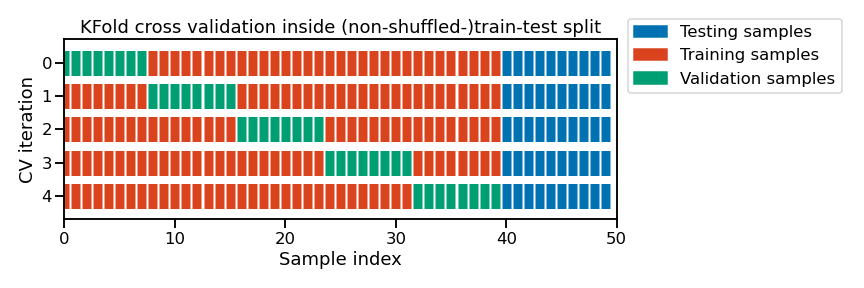

We could obtain this simply by calling in a new cell:

    accuracy = model_grid_search.score(data_test, target_test)
    print(f"Accuracy on test set: {accuracy:.3f}")

Suppose we call instead `cross_validate` on the grid search: the execution plan would looke like this instead:

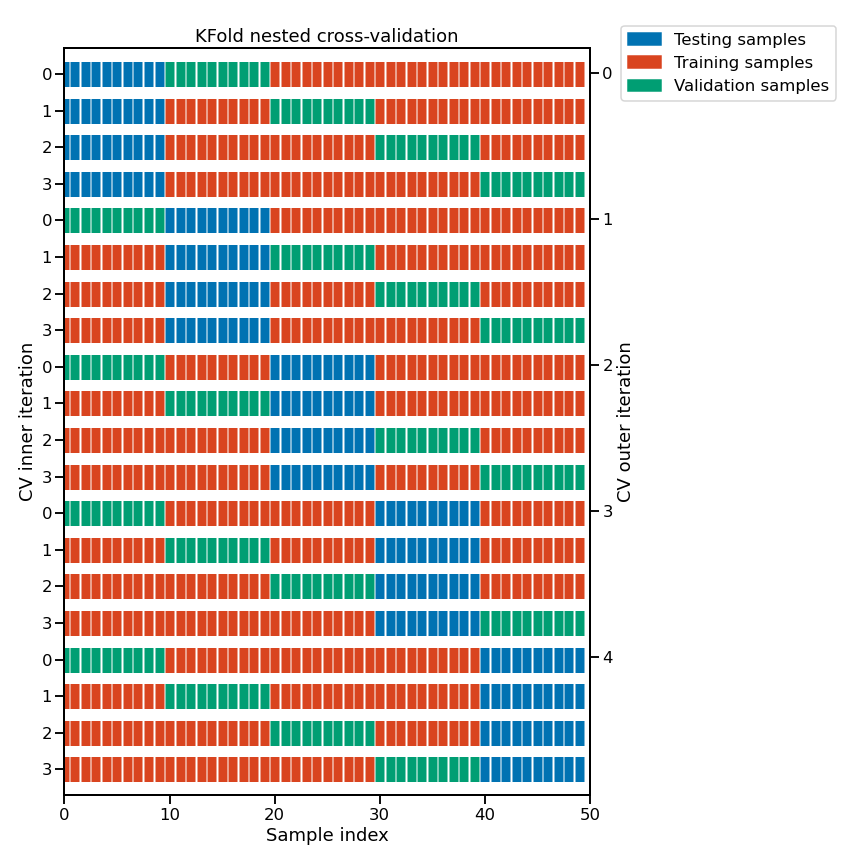

Here, the better model is trained on every red/green chunk and the score is computed once for each blue chunk. In our case, this would result in fitting $4 \times 3 \times 5 = 60$ models to find the better model, which would then be used to compute the score on the blue chunk... and this will happen four more times, for a total of **305 models being fitted**. Things can get out of hand pretty quickly!

In [ ]:
cv_results_gridsearch = cross_validate(
    model_grid_search, data, target, cv=5, n_jobs=-1, return_estimator=True
)

In [ ]:
cv_results_grid_df = pd.DataFrame(cv_results_gridsearch)
cv_test_scores = cv_results_grid_df['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

All of this and the generalisation error cannot be statistically distinguished from the "no-tuning" scenario: remember, the performance was 87.0 +/- 0.3, so there is a lot of overlapping. What could we do further to improve our model? We can employ more sophisticated hyperparameter tuning procedures, which could also scale better with the number of hyperparam combinations we want to use. But perhaps working on feature engineering might be a less complicated alternative: remember, training these expensive models can cost you money!

## References

https://inria.github.io/scikit-learn-mooc/index.html